In [2]:
# !pip install nibabel
# !pip install torch torchvision
# !pip install matplotlib
# !pip install scikit-image
# !pip install tqdm
# !pip install kagglehub


In [3]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

# print("Path to dataset files:", path)

In [5]:
# import os
# import shutil
# from tqdm import tqdm

# def copy_files_with_progress(src, dst):
#     # Get all files to copy
#     all_files = []
#     for root, dirs, files in os.walk(src):
#         for file in files:
#             all_files.append(os.path.join(root, file))

#     print(f"Total files to copy: {len(all_files)}")

#     for file_path in tqdm(all_files, desc="Copying files"):
#         relative_path = os.path.relpath(file_path, src)
#         dst_path = os.path.join(dst, relative_path)

#         os.makedirs(os.path.dirname(dst_path), exist_ok=True)
#         shutil.copy2(file_path, dst_path)

# # Usage
# destination_path = "/content/drive/MyDrive/DL_Project/dataset_BRATS2020"
# os.makedirs(destination_path, exist_ok=True)

# copy_files_with_progress(path, destination_path)

# print(f"Dataset copied to {destination_path}")


## VIEW SAMPLES

In [6]:
# imports
import os
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import h5py

from torch.utils.data import DataLoader

import torch.nn as nn
from tqdm import tqdm

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

Total h5 files found: 57195
Random sample selected: /kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_115_slice_71.h5


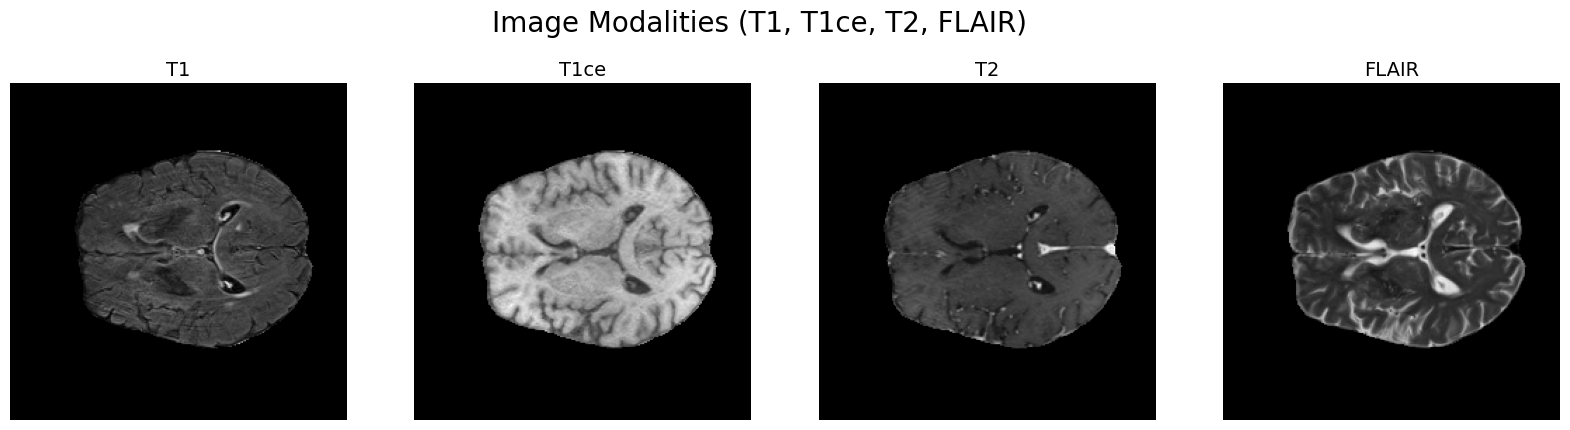

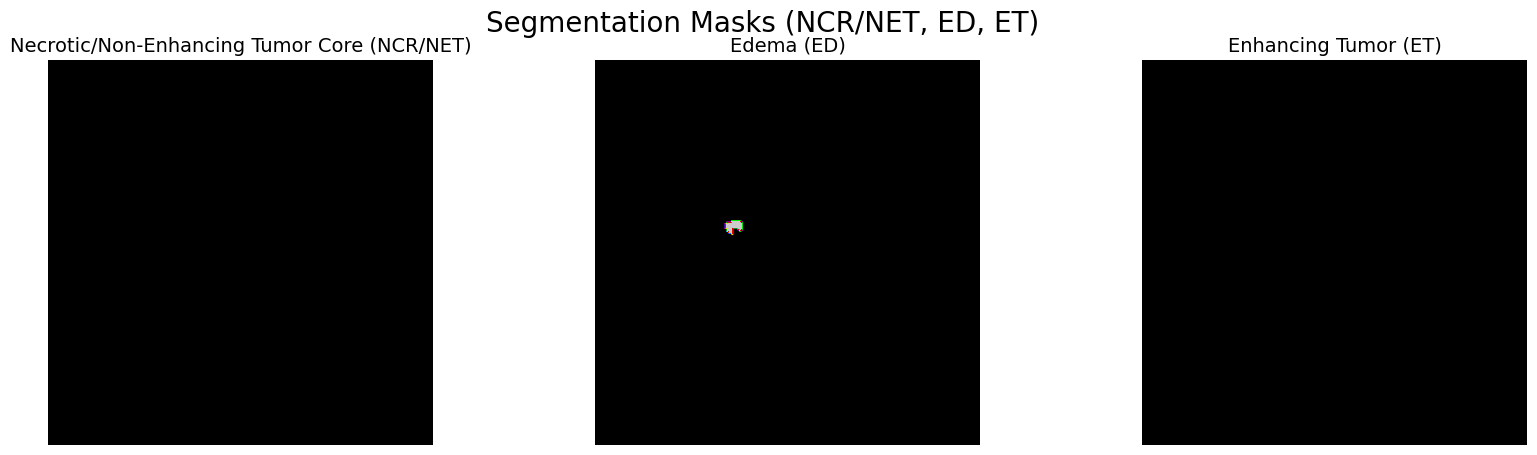

In [10]:
# Directory containing the dataset
dataset_dir = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

# Get all h5 files
h5_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.h5')]
print(f"Total h5 files found:", len(h5_files))
# Pick a random sample
sample_file = random.choice(h5_files)
print("Random sample selected:", sample_file)

# Load the sample
with h5py.File(sample_file, "r") as f:
    image = f["image"][:]
    mask = f["mask"][:]

# Transpose to (C, H, W)
image = np.transpose(image, (2, 0, 1))
mask = np.transpose(mask, (2, 0, 1))

# Visualization Functions

def display_image_channels(image, title='Image Modalities (T1, T1ce, T2, FLAIR)'):
    modality_labels = ['T1', 'T1ce', 'T2', 'FLAIR']

    plt.figure(figsize=(20, 5))

    for idx in range(4):
        plt.subplot(1, 4, idx + 1)
        plt.imshow(image[idx], cmap='gray')
        plt.title(modality_labels[idx], fontsize=14)
        plt.axis("off")

    plt.suptitle(title, fontsize=20)
    plt.show()

def display_mask_channels(mask, title='Segmentation Masks (NCR/NET, ED, ET)'):
    mask_labels = ['Necrotic/Non-Enhancing Tumor Core (NCR/NET)', 'Edema (ED)', 'Enhancing Tumor (ET)']
    cmap = 'nipy_spectral'

    plt.figure(figsize=(20, 5))

    for idx in range(3):
        plt.subplot(1, 3, idx + 1)
        plt.imshow(mask[idx], cmap=cmap)
        plt.title(mask_labels[idx], fontsize=14)
        plt.axis("off")

    plt.suptitle(title, fontsize=20)
    plt.show()

# Call the visualizations

display_image_channels(image)
display_mask_channels(mask)


## LOAD THE DATA INTO A DATALOADER

In [11]:
# Collect all h5 files
h5_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.h5')]
print("Total samples:", len(h5_files))

# Split into Train (60%) and Temp (40%)
train_files, temp_files = train_test_split(h5_files, test_size=0.4, random_state=42)

# Split Temp into Validation (20%) and Test (20%)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

print(f"Train: {len(train_files)} | Validation: {len(val_files)} | Test: {len(test_files)}")


Total samples: 57195
Train: 34317 | Validation: 11439 | Test: 11439


In [12]:
class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]

        with h5py.File(path, "r") as f:
            image = f["image"][:]
            mask = f["mask"][:]

        # (H, W, C) to (C, H, W)
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        # Normalize image to [0, 1]
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [13]:
train_dataset = BrainTumorSegmentationDataset(train_files)
val_dataset = BrainTumorSegmentationDataset(val_files)
test_dataset = BrainTumorSegmentationDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


## Defining the UNET model

In [14]:


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            activation
        )

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 3, padding=1),
            activation,
            nn.Conv2d(in_channels // 2, out_channels, 3, padding=1),
            activation
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, base_filters=32):
        super().__init__()

        self.down = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.enc1 = EncoderBlock(in_channels, base_filters)
        self.enc2 = EncoderBlock(base_filters, base_filters * 2)
        self.enc3 = EncoderBlock(base_filters * 2, base_filters * 4)
        self.enc4 = EncoderBlock(base_filters * 4, base_filters * 8)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_filters * 8, base_filters * 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_filters * 16, base_filters * 8, 3, padding=1),
            nn.ReLU()
        )

        self.dec4 = DecoderBlock(base_filters * 16, base_filters * 4)
        self.dec3 = DecoderBlock(base_filters * 8, base_filters * 2)
        self.dec2 = DecoderBlock(base_filters * 4, base_filters)
        self.dec1 = DecoderBlock(base_filters * 2, base_filters)

        self.output = nn.Conv2d(base_filters, out_channels, 1)

    def forward(self, x):
        s1 = self.enc1(x)
        x = self.down(s1)

        s2 = self.enc2(x)
        x = self.down(s2)

        s3 = self.enc3(x)
        x = self.down(s3)

        s4 = self.enc4(x)
        x = self.down(s4)

        x = self.bottleneck(x)

        x = self.up(x)
        x = torch.cat([x, s4], dim=1)
        x = self.dec4(x)

        x = self.up(x)
        x = torch.cat([x, s3], dim=1)
        x = self.dec3(x)

        x = self.up(x)
        x = torch.cat([x, s2], dim=1)
        x = self.dec2(x)

        x = self.up(x)
        x = torch.cat([x, s1], dim=1)
        x = self.dec1(x)

        return self.output(x)

## TRAINING

In [15]:
def dice_score(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice.mean()

In [16]:
def train_model(model, train_loader, val_loader, config):
    device = config['device']
    n_epochs = config['n_epochs']
    lr = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []
    train_dice_scores, val_dice_scores = [], []

    print("Starting training...\n")

    for epoch in range(1, n_epochs + 1):
        current_lr = lr * (lr_decay ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # --- Training ---
        model.train()
        train_loss = 0
        train_dice = 0

        train_loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch}", leave=False)

        for batch_idx, (inputs, targets) in enumerate(train_loop, start=1):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_dice += dice_score(outputs, targets).item()

            train_loop.set_postfix({"Loss": loss.item()})

            if batch_idx >= batches_per_epoch:
                break

        avg_train_loss = train_loss / batches_per_epoch
        avg_train_dice = train_dice / batches_per_epoch
        train_losses.append(avg_train_loss)
        train_dice_scores.append(avg_train_dice)

        # --- Validation ---
        model.eval()
        val_loss = 0
        val_dice = 0

        val_loop = tqdm(val_loader, desc=f"[Val] Epoch {epoch}", leave=False)

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loop, start=1):
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_dice += dice_score(outputs, targets).item()

                val_loop.set_postfix({"Loss": loss.item()})

                if batch_idx >= batches_per_epoch:
                    break

        avg_val_loss = val_loss / batches_per_epoch
        avg_val_dice = val_dice / batches_per_epoch
        val_losses.append(avg_val_loss)
        val_dice_scores.append(avg_val_dice)

        # --- Epoch Summary ---
        print(f"Epoch {epoch}/{n_epochs} | Train Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f} | Val Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f} | LR: {current_lr:.6f}")

    print("Training complete.")
    return train_losses, val_losses, train_dice_scores, val_dice_scores

In [18]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'batches_per_epoch': 100,
    'lr_decay_factor': 1
}

model = UNet()
train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

train_losses, val_losses, train_dices, val_dices = train_model(model, train_loader, val_loader, train_config)

Starting training...



Epoch 1/10 | Train Loss: 0.0547, Dice: 0.5051 | Val Loss: 0.0143, Dice: 0.5691 | LR: 0.001000


Epoch 2/10 | Train Loss: 0.0119, Dice: 0.5931 | Val Loss: 0.0104, Dice: 0.6572 | LR: 0.001000


Epoch 3/10 | Train Loss: 0.0100, Dice: 0.6560 | Val Loss: 0.0093, Dice: 0.6656 | LR: 0.001000


Epoch 4/10 | Train Loss: 0.0090, Dice: 0.6734 | Val Loss: 0.0088, Dice: 0.6851 | LR: 0.001000


Epoch 5/10 | Train Loss: 0.0087, Dice: 0.6717 | Val Loss: 0.0082, Dice: 0.6914 | LR: 0.001000


Epoch 6/10 | Train Loss: 0.0078, Dice: 0.7042 | Val Loss: 0.0073, Dice: 0.7318 | LR: 0.001000


Epoch 7/10 | Train Loss: 0.0076, Dice: 0.7224 | Val Loss: 0.0073, Dice: 0.6290 | LR: 0.001000


Epoch 8/10 | Train Loss: 0.0071, Dice: 0.7319 | Val Loss: 0.0077, Dice: 0.7250 | LR: 0.001000


Epoch 9/10 | Train Loss: 0.0062, Dice: 0.7537 | Val Loss: 0.0065, Dice: 0.7712 | LR: 0.001000


Epoch 10/10 | Train Loss: 0.0073, Dice: 0.7366 | Val Loss: 0.0064, Dice: 0.7601 | LR: 0.001000
Training complete.


In [19]:
def plot_training_curves(train_losses, val_losses, train_scores=None, val_scores=None, score_name="Dice Score"):
    """
    Plots training and validation loss (and optionally accuracy/Dice Score) curves.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        train_scores (list, optional): List of training scores per epoch.
        val_scores (list, optional): List of validation scores per epoch.
        score_name (str, optional): Name of the score metric. Defaults to "Dice Score".
    """
    epochs = range(1, len(train_losses) + 1)
    num_plots = 2 if train_scores is not None and val_scores is not None else 1

    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, num_plots, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Plot Score (optional)
    if train_scores is not None and val_scores is not None:
        plt.subplot(1, num_plots, 2)
        plt.plot(epochs, train_scores, label=f"Train {score_name}", marker='o')
        plt.plot(epochs, val_scores, label=f"Validation {score_name}", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel(score_name)
        plt.title(f"Train vs Validation {score_name}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


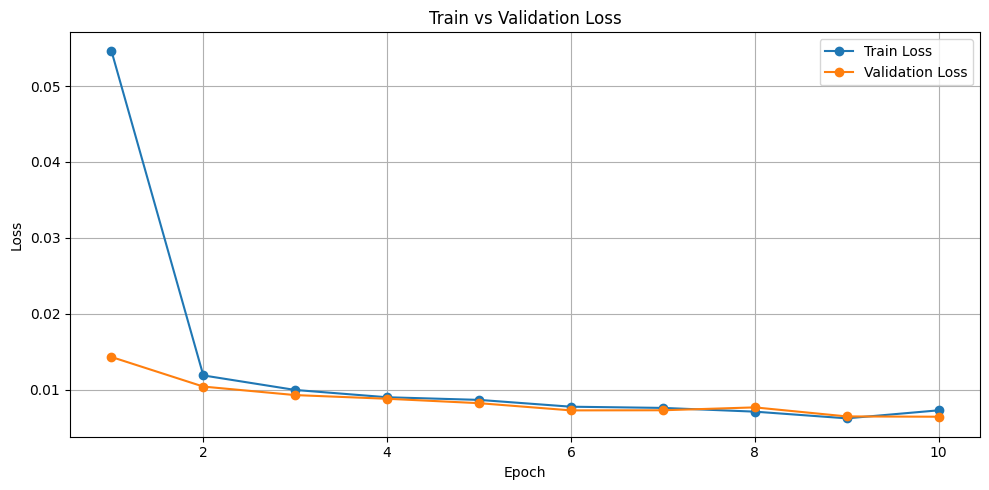

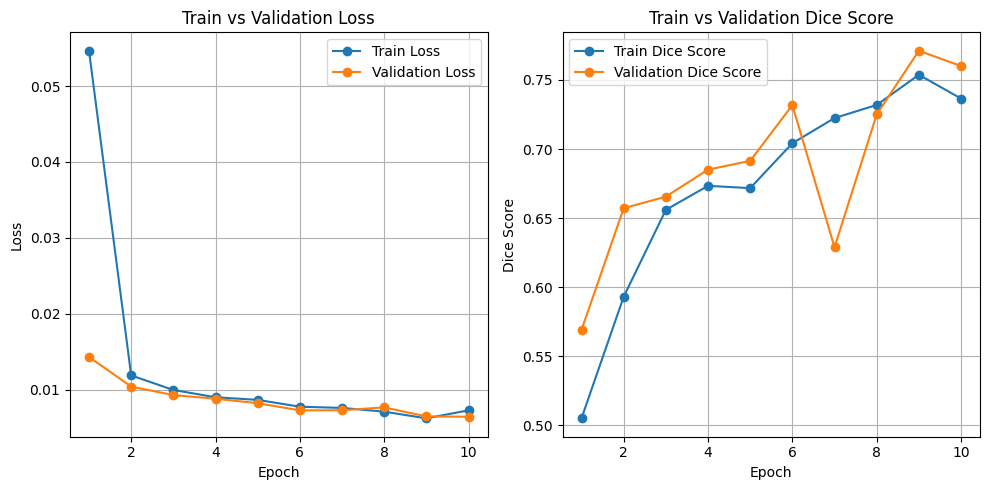

In [20]:
# Just plot losses
plot_training_curves(train_losses, val_losses)

# Plot losses + dice scores
plot_training_curves(train_losses, val_losses, train_dices, val_dices, score_name="Dice Score")


In [23]:
# Save
torch.save(model.state_dict(), "unet_brats2020.pth")

## EVALUATE THE MODEL

In [27]:
def evaluate_model(model, dataloader, device, batches_to_evaluate=None):
    model.eval()
    criterion = nn.BCEWithLogitsLoss()

    total_loss = 0
    total_dice = 0
    num_batches = 0

    loop = tqdm(dataloader, desc=f"[Test]", leave=False)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loop, start=1):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            total_dice += dice_score(outputs, targets).item()

            loop.set_postfix({"Loss": loss.item()})

            num_batches += 1
            if batches_to_evaluate is not None and batch_idx >= batches_to_evaluate:
                break

    avg_loss = total_loss / num_batches
    avg_dice = total_dice / num_batches

    print(f"[TEST] Avg Loss: {avg_loss:.4f}, Avg Dice: {avg_dice:.4f}")

    return avg_loss, avg_dice


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet().to(device)
state_dict = torch.load("unet_brats2020.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()


/tmp/ipykernel_152/3468732368.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("unet_brats2020.pth", map_location=device)


UNet(
  (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (enc1): EncoderBlock(
    (block): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (enc2): EncoderBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (enc3): EncoderBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (enc4): EncoderBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

In [31]:
test_loss, test_dice = evaluate_model(model, test_loader, device)


[TEST] Avg Loss: 0.0066, Avg Dice: 0.7574
